# <font color=#cd0000> Propósito principal </font>
- La idea de este librillo es estudiar la composición y la forma de los datos del conjunto de datos Seguimiento Ocular

## <font color=#cd0000> Leyenda </font>
- Los apartados titulados con el código de colores HEX: `#cd0000` serán apartados que tendrán todos los librillos, en concreto, aquellos especificados en el apartado `Síntesis de los criterios usados` del trabajo.
- Los apartados titulados con el código de colores HEX: `#2451ff` serán apartados de conclusiones propias de este librillo resultado de aplicar un estudio personalizado para cada planteamiento.

# <font color=#cd0000> Prerrequisitos </font>
## <font color=#cd0000> Entorno de ejecución </font>
- Cambiamos el directorio raíz del librillo para acceder cómodamente a las funciones de utilidad.

In [1]:
import os

os.chdir('../../')
os.listdir()


['.git',
 '.gitignore',
 '.gitmodules',
 'data',
 'HeartBeat_tmp_test_data.pkl',
 'HeartBeat_tmp_train_data.pkl',
 'pkl',
 'Pruebas',
 'README.md',
 'smts_implementation',
 'utils']

## <font color=#cd0000> Constantes y variables predefinidas </font>

In [2]:
SEGUIMIENTO_OCULAR_PATH = "data/seguimiento-ocular/Data/Hospital"
SEGUIMIENTO_OCULAR_FOLDERS_ID = range(1, 12+1)

SEED = 1


# <font color=#cd0000> Análisis del Dataset Seguimiento Ocular </font>
- Fuente: TFM Marta Couce Iglesias -> http://hdl.handle.net/10486/697441

## <font color=#cd0000> Extracción de datos </font>

In [3]:
from utils.load_data import import_seguimiento_ocular_dataset

all_data = import_seguimiento_ocular_dataset(
    SEGUIMIENTO_OCULAR_PATH, SEGUIMIENTO_OCULAR_FOLDERS_ID)


In [4]:
all_data.reset_changes()

## <font color=#cd0000> Generación automática de reporte estadístico </font>
- Puedes observar el reporte generado en el directorio raíz del proyecto con un navegador tras ejecutar esta celda.

In [5]:
# import pandas_profiling

# report = pandas_profiling.ProfileReport(all_data.original_data)
# report.to_file(output_file="segocular_report.html")

## <font color=#cd0000> Análisis a simple vista </font>
- Analizaremos los datos generados por el reporte automático de estadísticas brindado por Pandas-Profiling.

### <font color=#cd0000> Concentración de los datos </font>
- No observamos que los datos se encuentren normalizados, diferentes atributos se encuentran en diferentes rangos de valores.

### <font color=#cd0000> Missing Values </font>
- Existen missing values -> todos aquellos con un "-1" en cualquiera de las dimensiones (deberemos eliminarlos).
- En vista de que tendremos series con diferentes longitudes será necesario aplicar algún tipo de enventanado o truncar las series al tamaño de la más pequeña.

### <font color=#cd0000> Matriz de correlación </font>
- Estudiando la matriz de correlación generada a partir del coeficiente de correlación de Pearson observamos que:
  - Como es evidente observamos una alta correlación entre los atributos que indican la validez de una columna y la propia columna.
  - Como también es evidente observamos cierta correlación entre los atributos X e Y de cada columna en concreto entre los atributos:
    - GazePointX junto con GazePointXLeft y GazePointXRight puesto que GazePointX es una combinación lineal entre GazePointXLeft (coordenada X del punto al que mira el ojo izquierdo) y GazePointXRight (coordenada X del punto al que mira el ojo derecho), en concreto, la media.
    - Lo mismo del párrafo anterior ocurre con GazePointY.

### <font color=#cd0000> Balanceo de las clases </font>
- Observamos que nuestro conjunto de datos contiene 25 series temporales:
  - 17 de la clase ``Estudio``.
  - 8 de la clase ``Control``.
- Será necesario aplicar un balanceo de clases pues tenemos el doble de una clase que de otra.

## <font color=#cd0000> Análisis en profundidad </font>
- Analizaremos las series de cada atributo en mayor profundidad.

### <font color=#cd0000> Disminución de la dimensionalidad </font>
- Será necesario reducir la dimensionalidad, pero en este caso habrá que hacerlo después de la limpieza de datos pues hay columnas con información imprescindible que nos indican si existen datos inválidos.
- Las columnas a eliminar después de dicha limpieza de datos serán:
  - `diagnosis` -> Esta columna corresponde con las clases de la clasificación multiclase que no trataremos en este estudio.
  - `Age` -> Esta columna podría ser interesante en estudios con una cantidad masiva de datos, no obstante, en este estudio reducido podría sesgar a los clasificadores puesto que tenemos pocos pacientes.
  - `*Validity*` -> Estas columnas indican la validez de las demás y habrá que eliminar aquellas muestras que presenten un ``0`` en esta columna.
  - `GazePointX` -> Eliminamos esta columna porque es una combinación lineal de `GazePointXLeft` y `GazePointXRight` y puede ser inferida por el clasificador. No eliminamos `GazePointXLeft` ni `GazePointXRight` a cambio de quedarnos con `GazePointX` ya que dicha información puede ser significativa al tratarse del comportamiento individual de cada ojo.
  - `GazePointY` -> Eliminamos esta columna por las mismas razones que `GazePointX`.
- Esto nos dejará con 6 atributos informativos.

### <font color=#2451ff> Limpieza de datos </font>
- Esta operación será necesaria antes de eliminar los atributos mencionados puesto que, de lo contrario, no conoceremos que registros son válidos.

In [6]:
# Clean data
validity_headers = ['ValidityLeft',
                    'ValidityRight',
                    'PupilValidityLeft',
                    'PupilValidityRight']

all_data.clean_data(criterion='remove', value=0, headers=validity_headers)

In [7]:
# Reduce data
columns_to_remove = validity_headers + ['GazePointX', 'GazePointY',
                                        'diagnosis', 'Age']

all_data.drop_derived_data_columns(columns_to_remove)

id  TimeStamp  GazePointXLeft  GazePointYLeft  GazePointXRight  \
0       1-1    704.487             875             549              771   
1       1-1    750.040             879             519              796   
2       1-1    776.032             898             547              785   
3       1-1    831.135             882             563              768   
4       1-1    857.075             879             513              789   
...     ...        ...             ...             ...              ...   
36362  12-3  54379.209             162             808              263   
36363  12-3  54406.850             136             816              272   
36364  12-3  54433.946             122             942              191   
36365  12-3  54460.926             326             918              364   
36366  12-3  54487.080             354             938              363   

       GazePointYRight  PupilSizeLeft  PupilSizeRight    class  
0                  284         2.1565          2.1575  Control  
1                  245         2.0449          2.1528  Control  
2                  316         2.1199          2.1833  Control  
3                  322         2.1039          2.3215  Control  
4                  362         2.0490          2.4636  Control  
...                ...            ...             ...      ...  
36362              944         2.6453          2.4885  Estudio  
36363              969         2.6189          2.4906  Estudio  
36364              854         2.5684          2.2774  Estudio  
36365              936         2.3562          2.6705  Estudio  
36366              988         2.2507          2.5588  Estudio  

[36367 rows x 9 columns]

### <font color=#2451ff> Generación automática de reporte estadístico con reducción de la dimensionalidad </font>
- Este reporte puede ser visualizado en el propio librillo

In [8]:
import pandas_profiling

pandas_profiling.ProfileReport(all_data.derived_data)

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


### <font color=#cd0000> Desplazamiento de las series </font>
- No se observa un desplazamiento entre las series del mismo tipo (`gz_x_*` es un tipo, `gz_y_*` es otro y `pupil_size_*` otro) como era de esperar.
- Sin embargo, con respecto a diferentes tipos observamos que, salvo el tamaño de la pupila que lo debemos observar a parte por tener una escala diferente, avanzan a la par.
  - Se produce una tendencia ascendente cuando el paciente termina de leer la línea (llega a la derecha del todo).
- Con respecto al tamaño de la pupila, observamos que suelen producirse picos ascendentes cuando el paciente cambia de línea por lo que podríamos decir que avanzan a la vez.

In [9]:
from utils.plot_utils import plot_series


def plot_all_signals_from_serie_id(df, id):
    serie_id = id

    gz_x_left_serie = df[df['id'] == serie_id]['GazePointXLeft']
    gz_x_right_serie = df[df['id'] == serie_id]['GazePointXRight']
    gz_y_left_serie = df[df['id'] == serie_id]['GazePointYLeft']
    gz_y_right_serie = df[df['id'] == serie_id]['GazePointYRight']
    pupil_size_left_serie = df[df['id'] == serie_id]['PupilSizeLeft']
    pupil_size_right_serie = df[df['id'] == serie_id]['PupilSizeRight']

    series_to_plot = [gz_x_left_serie, gz_x_right_serie, gz_y_left_serie,
                      gz_y_right_serie, pupil_size_left_serie, pupil_size_right_serie]

    labels = ["gz_x_left_serie",
              "gz_x_right_serie",
              "gz_y_left_serie",
              "gz_y_right_serie",
              "pupil_size_left_serie",
              "pupil_size_right_serie"]

    plot_series(series_to_plot, labels)


#### <font color=#2451ff> Clase Control </font>
- Observamos que hay algunos saltos en línea recta -> esto son los missing values de los que hablábamos así que deberemos ignorarlos.
- Con respecto al desplazamiento de las series observamos que todas avanzan a la par como ya comentábamos, en especial, los atributos `PupilSize*` que parecen tener valores equivalentes en instantes temporales adyacentes.
  - Si bien es cierto se producen algunas desincronizaciones (picos en una pupila y no en la otra), pero estas no persisten en el tiempo.

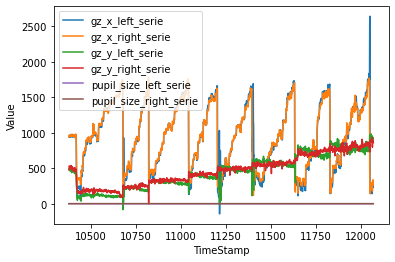

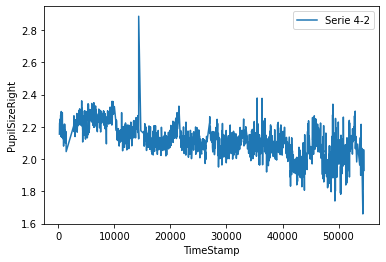

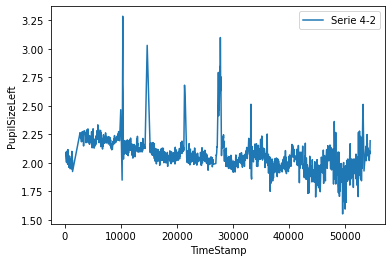

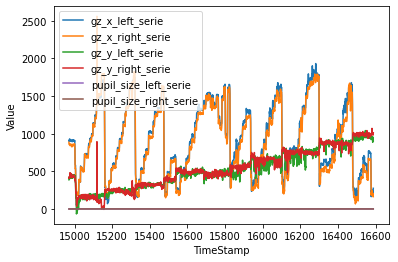

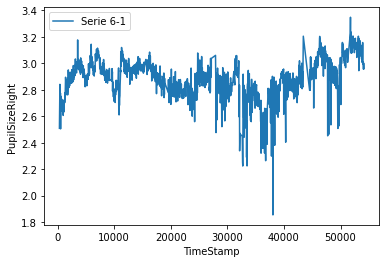

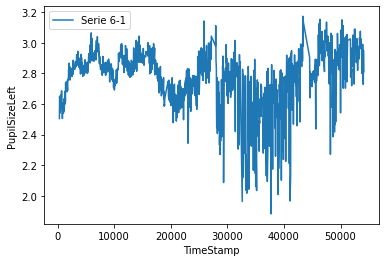

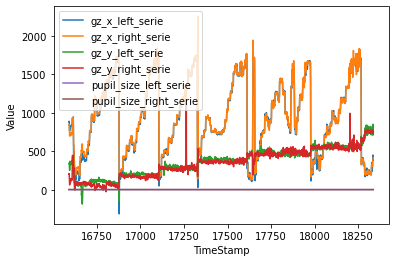

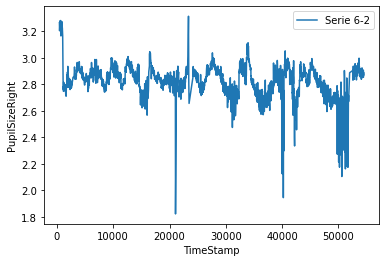

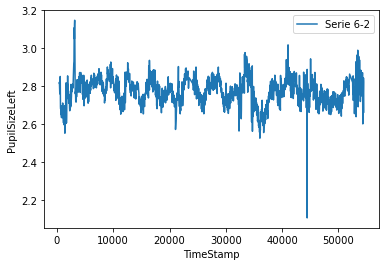

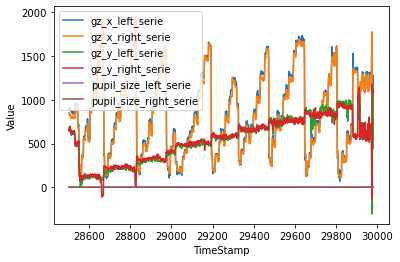

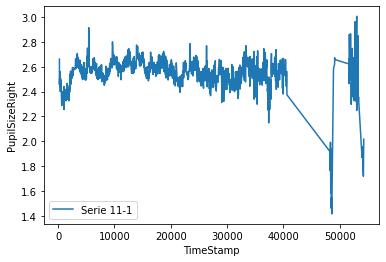

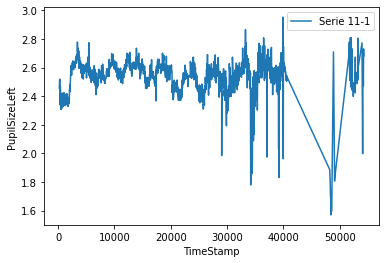

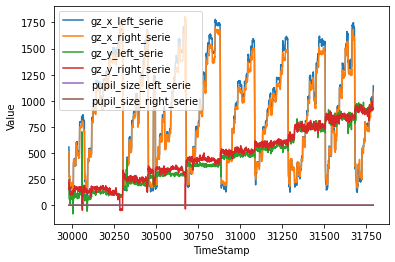

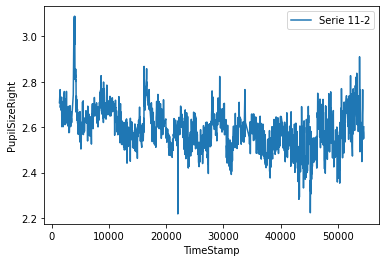

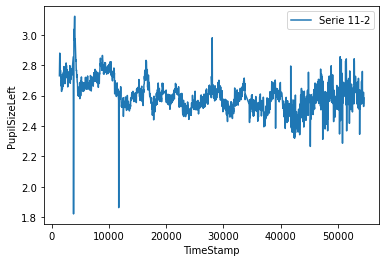

In [10]:
import pandas as pd
%matplotlib inline

identificators = pd.unique(
    all_data.derived_data[all_data.derived_data['class']=='Control']['id'])

for identificator in identificators[-5:]:
    plot_all_signals_from_serie_id(all_data.derived_data, identificator)
    all_data.plot_series_by_id([identificator], 'PupilSizeRight')
    all_data.plot_series_by_id([identificator], 'PupilSizeLeft')


#### <font color=#2451ff> Clase Estudio </font>
- En esta clase observamos que hay algo de disparidad en los atributos lo que puede ser determinante para clasificar al paciente en esta clase. En especial, para los atributos `PupilSize*` se observa que el tamaño de la pupila izquierda no siempre contiene valores iguales a los de la pupila derecha en instantes de tiempo adyacentes como sí pasaba en la clase `Control`.
- También observamos cierto "temblor" en las señales `GazePointY*` que hace que pierdan la sincronización que observábamos en las series de clase `Control`.
- Para capturar estos cambios creemos que la información a corto plazo jugará un papel relevante por lo que, mantener la resolución y aplicar una codificación como la Tendencia y la Aceleración será de gran ayuda. No obstante, también hay pacientes sanos con los "temblores" y desincronizaciones en las pupilas. Sin embargo, esta situación no persiste en el tiempo por lo que mantener también la información temporal a un más largo plazo (aunque no es necesario mucho) será de gran utilidad para clasificar correctamente.

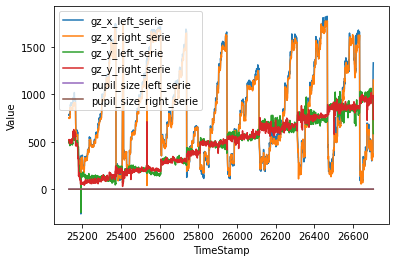

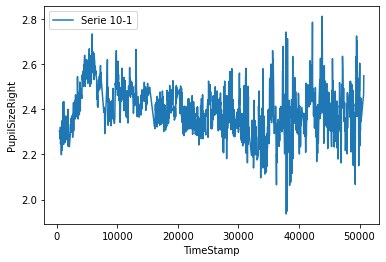

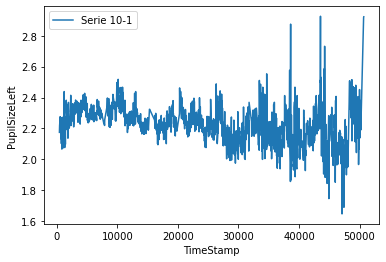

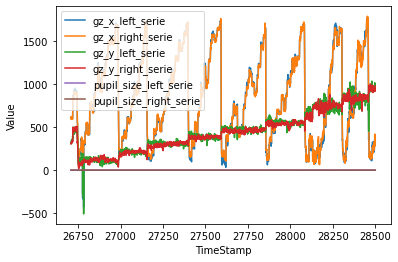

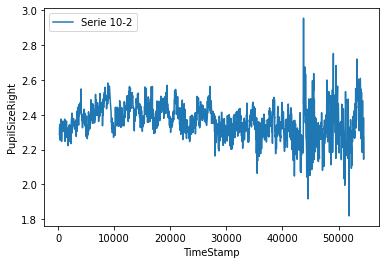

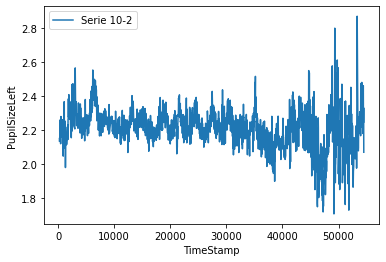

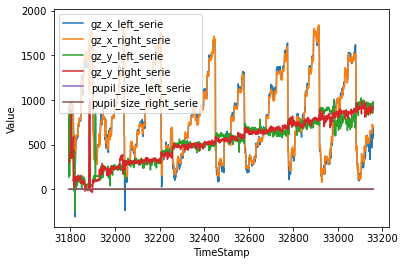

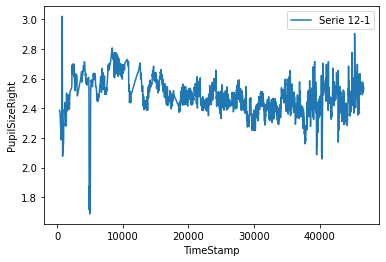

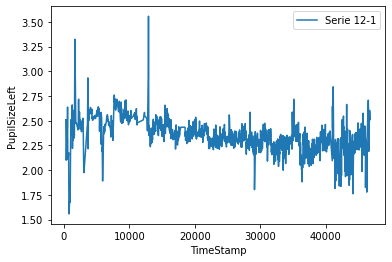

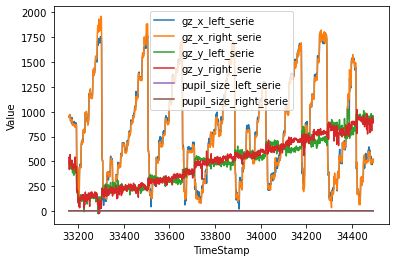

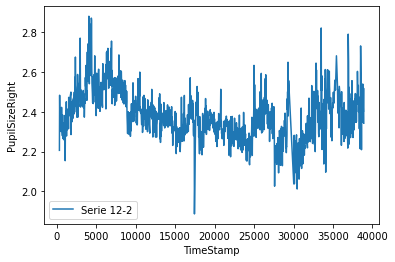

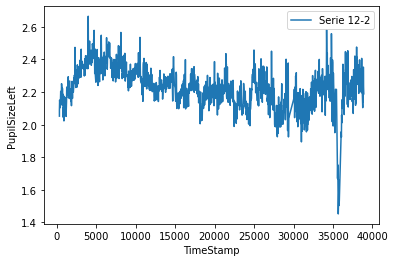

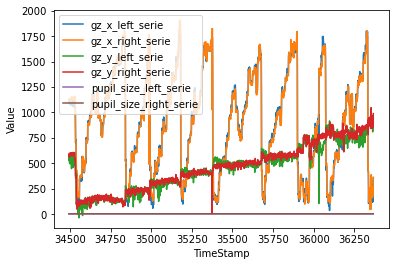

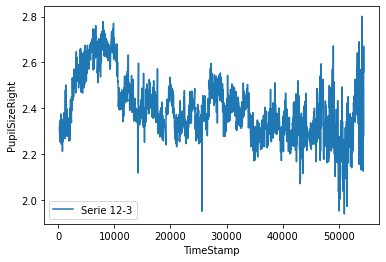

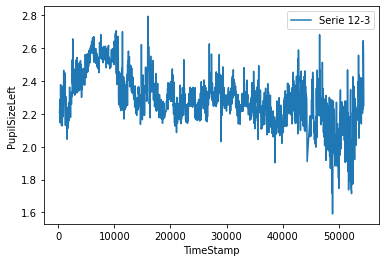

In [11]:
import pandas as pd
%matplotlib inline

identificators = pd.unique(
    all_data.derived_data[all_data.derived_data['class']=='Estudio']['id'])

for identificator in identificators[-5:]:
    plot_all_signals_from_serie_id(all_data.derived_data, identificator)
    all_data.plot_series_by_id([identificator], 'PupilSizeRight')
    all_data.plot_series_by_id([identificator], 'PupilSizeLeft')


### <font color=#cd0000> Variabilidad y velocidad de cambios por clase </font>
- En general, podemos observar que los atributos presentan diferentes velocidades de cambios:
  - Los atributos `GazePoint*` parecen presentar series que se repiten con una forma cuasi-periódica a lo largo del tiempo y no cambian a valores radicales constantemente por lo que podríamos crear modelos menos complejos que capturasen dichos cambios con mayor facilidad.
  - Los atributos `PupilSize*` presentan series que cambian con bastante más frecuencia que los `GazePoint*` por lo que convendría aumentar la complejidad de los modelos para capturar su variabilidad.
- En vista de lo anterior será interesante mantener la resolución actual e incluso disminuirla para ajustar mejor los atributos `GazePoint*` bajo el riesgo de perder información sobre `PupilSize*`.

#### <font color=#2451ff> Clase Control </font>
- Observamos lo mismo que lo descrito anteriormente solo que, los atributos `PupilSize*`, presentan una variabilidad más baja que los de la clase Estudio y podrían ser estudiados con clasificadores menos complejos e incluso a resoluciones más bajas porque cambian menos en el tiempo (más lentas).

#### <font color=#2451ff> Clase Estudio </font>
- Observamos lo mismo que lo descrito anteriormente solo que, los atributos `PupilSize*`, presentan una variabilidad/complejidad más alta que los de la clase Control, por ende, de querer clasificar esta clase con mayor precisión convendría aumentar la complejidad de los modelos o la resolución de las series.

### <font color=#cd0000> Estacionariedad de las series </font>
- Podemos observar que nos enfrentamos a series no estacionarias aunque, algunos de los atributos, podríamos considerarlos cuasi-periódicos. En concreto:
  - `GazePointX*`
  - `GazePointY*`

### <font color=#cd0000> Tendencia de las series </font>
- No observamos una tendencia en ninguno de los atributos salvo los del tipo `GazePointY*` lo que tiene sentido pues, el paciente, baja/sube la mirada conforme cambia de linea y esto queda correctamente registrado por el dispositivo.
- También observamos que dicha tendencia es ascendente y se da cuando termina de leer la línea, es decir, cuando `GazePointX*` presenta un pico de bajada importante (va al principio de la línea siguiente).
  - Esta tendencia ascendente se da a corto plazo así que será importante considerar dicha información y, con el uso de la `Tendencia` y `Aceleración`, seremos capaces de conseguirlo.

#### <font color=#cd0000> Normalización de los datos </font>
- Observamos que mantenemos la tendencia de la información correctamente representada y logramos hace que `PupilSize*` se ajuste a un intervalo en que se considere importante para clasificadores basados en la escala.

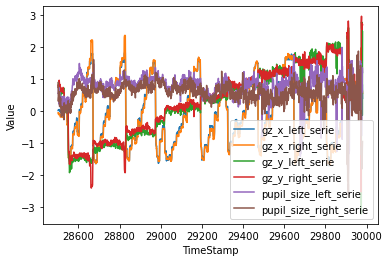

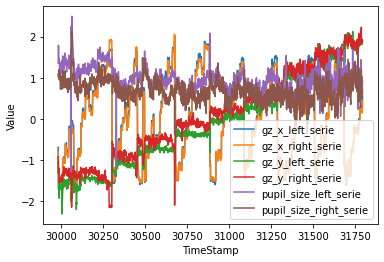

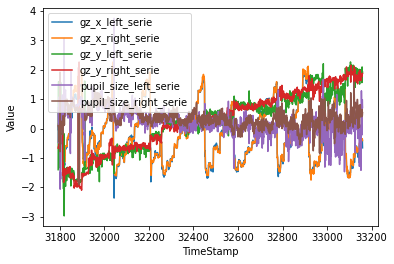

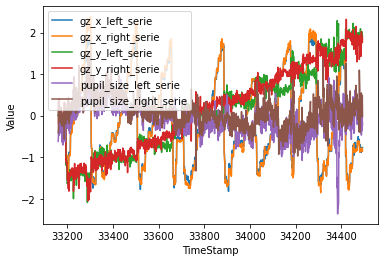

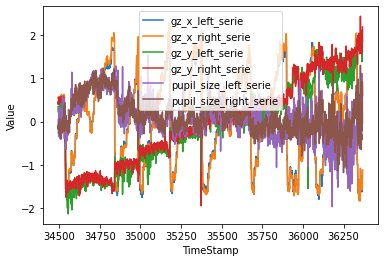

In [12]:
from utils.codifications import standardize_data

columns = all_data.get_derived_data_columns()['attrs']
standardized_data = standardize_data(all_data.derived_data, headers=columns)

identificators = pd.unique(standardized_data['id'])

for identificator in identificators[-5:]:
    plot_all_signals_from_serie_id(standardized_data, identificator)


### <font color=#2451ff> Partición del conjunto de datos </font>
- Historial:
  - Probamos a dar a los clasificadores una partición estratificada con 4 ventanas por serie donde, cada serie completa se encontraba o bien en train o bien en test:
    - Para asegurarnos de que la información era suficiente en cada ventana nos aseguramos de eliminar las series con un número menor de muestras a 500 (ante la eliminación de los valores inválidos registrados por el dispositivo de seguimiento ocular). En concreto:
      - Dado que el modo de partición de datos que buscábamos es `windowed`, véase los `mode` del método `train_test_split` en `data_extraction.py` (todas las ventanas de una serie en una partición concreta) para aprovechar a no sesgar el clasificador, habrá series completas en train y test. Por lo que el nº de ventanas que contengan deberá ser proporcional al nº de ventanas extraídas de cada serie (en el caso de elegir `n_windows`, sino, se complica la cosa porque no sabemos cuántas ventanas deberían ir a cada partición):
        - 80% -> Train y 20% -> Test -> Train (72 series): 44 de Estudio y 28 de Control; Test (20 series): 12 de Estudio y 8 de Control
          - En Train habrá ventanas de -> 18 series (44 ventanas/4 ventanas por serie + 28 vent/4 vent por serie) y, en Test, de 5 (12/4 + 8/4) -> 23 series en total.
          - Eliminamos las series 8-1 y 8-2 por tener 72 y 202 muestras, respectivamente (muy pocas).
    - Los resultados de este planteamiento fueron bastante negativos lo que es de esperar de un conjunto de datos tan reducido.
  - Volvimos a estudiar el TFM de Marta Couce y observamos que utiliza un método de partición que permite observar la influencia de la codificación mucho mejor que el que venimos utilizando hasta ahora para este conjunto de datos en especial:
    - Este método consiste en dividir cada serie en un nº de ventanas determinado para tomar un determinado porcentaje y asignarlo al conjunto de validación mientras, el resto, se almacena en el conjunto de entrenamiento.
    - Sin embargo, a pesar de que las ventanas para cada partición son escogidas aleatoriamente, consideramos este método menos robusto que el que veníamos usando hasta ahora debido a que, tanto en el conjunto de entrenamiento como en el de validación, tendremos ventanas de una misma serie temporal, es decir, datos de un mismo paciente. De este modo podríamos estar sesgando al modelo validándolo con datos posteriores o anteriores a los entrenados, pero no contamos con los datos suficientes como para mejorar estas condiciones.

### <font color=#2451ff> Tamaños de ventana evaluados </font>
- El tamaño de ventana depende mucho de la velocidad de lectura del paciente, pues estas series serán más rápidas si el paciente es ágil leyendo y viceversa por lo que, para contener todas las posibles velocidades de lectura deberemos dividir las series en ventanas tan grandes que sean capaces de capturar lo equivalente a algunas lineas leídas.
  - Por lo tanto, al principio, intuimos que a menor tamaño de ventana mejor, entonces, probamos desde aplicar un enventanado muy grande (2 ventanas por serie) para cada serie hasta aplicar un enventanado más alto de lo recomendado (la serie más larga es de 1901 muestras tras la limpieza de valores inválidos, dividirla en 32 ventanas implicaría tener 59 muestras por ventana lo que son: $\frac{59 muestras}{30 Hz (\frac{muestras}{segundos})} = 2 segundos$ de lectura y esto no es suficiente ni como para leer una línea de texto).

- Puntuación por número de ventanas, clasificador sin optimizar y codificación: (Macro Avg F1-Score)
  - 1 (sin enventanado):
    - SMTS
      - CodifSimb: 0.33
      - CodifSimb + Trend: 0.33
      - CodifSimb + Trend + Acc: 0.33
    - RF
      - Raw: 0.46
      - Trend: 0.49
      - Trend + Acc: 0.48
    - LSTM: 
      - Raw: 0.34
      - Trend: 0.34
      - Trend + Acc: 0.33
  - 2:
    - SMTS
      - CodifSimb: 0.69
      - CodifSimb + Trend: 0.69
      - CodifSimb + Trend + Acc: 0.69
    - RF
      - Raw: 0.60
      - Trend: 0.63
      - Trend + Acc: 0.63
    - LSTM: 
      - Raw: 0.57
      - Trend: 0.55
      - Trend + Acc: 0.56
  - 4:
    - SMTS
      - CodifSimb: 0.86
      - CodifSimb + Trend: 0.79
      - CodifSimb + Trend + Acc: 0.90
    - RF
      - Raw: 0.63
      - Trend: 0.66
      - Trend + Acc: 0.67
    - LSTM: 
      - Raw: 0.64
      - Trend: 0.69
      - Trend + Acc: 0.67
  - 8:
    - SMTS
      - CodifSimb: 0.86
      - CodifSimb + Trend: 0.88
      - CodifSimb + Trend + Acc: 0.86
    - RF
      - Raw: 0.71
      - Trend: 0.74
      - Trend + Acc: 0.74
    - LSTM: 
      - Raw: 0.70
      - Trend: 0.75
      - Trend + Acc: 0.72
  - 16:
    - SMTS
      - CodifSimb: 0.79
      - CodifSimb + Trend: 0.90
      - CodifSimb + Trend + Acc: 0.95
    - RF
      - Raw: 0.80
      - Trend: 0.83
      - Trend + Acc: 0.84
    - LSTM: 
      - Raw: 0.78
      - Trend: 0.81
      - Trend + Acc: 0.79
  - 32:
    - SMTS
      - CodifSimb: 0.84
      - CodifSimb + Trend: 0.86
      - CodifSimb + Trend + Acc: 0.90
    - RF
      - Raw: 0.86
      - Trend: 0.87
      - Trend + Acc: 0.87
    - LSTM: 
      - Raw: 0.82
      - Trend: 0.84
      - Trend + Acc: 0.85

- También hemos probado a reducir la frecuencia de medida a 15 Hz y 7.5 Hz y la puntuación disminuía ligeramente en todos los casos.

### <font color=#2451ff> Conclusiones </font>
- Contraintuitivamente observamos que, a mayor número de ventanas, mejores puntuaciones en todos los clasificadores, no obstante, según va aumentando el número de ventanas, la codificación que se aplique, importa menos (porque obtenemos los mismos resultados) y esto puede deberse a dos motivos:
  1. Estamos sesgando demasiado a los modelos validándolos con piezas que faltan de las series temporales y, cuanto más fragmentamos la serie, más fácil es para el modelo hallar esas relaciones.
  2. Estamos localizando la información mediante el uso de enventanado y eso nos permite extraer relaciones a medio plazo con mayor facilidad de la serie por lo que, en esta serie, la relación a corto y medio plazo es importante para determinar la clase (en el momento en que existan cambios muy bruscos podemos conocer de qué clase es la serie como ya anticipábamos en el análisis de Variabilidad y velocidad de cambios por clase y en el de Desplazamiento de los atributos por clase).
- Para evitar el primer escenario no escogeremos un número de ventanas muy grande y elegiremos uno en el que la codificación presente cambios notables como puede ser el caso de utilizar 4 ventanas y manteniendo la resolución actual.

In [13]:
import pandas as pd

avg_serie_samples = 0
identificators = pd.unique(all_data.derived_data['id'])
for identificator in identificators:
    avg_serie_samples += all_data.derived_data[
        all_data.derived_data['id'] == identificator].shape[0]
avg_serie_samples /= len(identificators)

print("Series\' number: {}".format(len(identificators)))
print("Largest serie's samples: {}".format(
    all_data.get_largest_serie().shape[0]))
print("Average serie's samples: {}".format(avg_serie_samples))
print("Shortest serie's samples: {}".format(
    all_data.get_shortest_serie().shape[0]))


Series' number: 25
Largest serie's samples: 1901
Average serie's samples: 1454.68
Shortest serie's samples: 72


In [14]:
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-1'] # 72 samples
all_data.derived_data = all_data.derived_data[
    all_data.derived_data['id'] != '8-2'] # 202 samples

all_data.split_into_windows(n_windows=8)
# all_data.reduce_sampling_rate(remove_one_each_n_samples=2)
# all_data.reduce_sampling_rate(remove_one_each_n_samples=2)


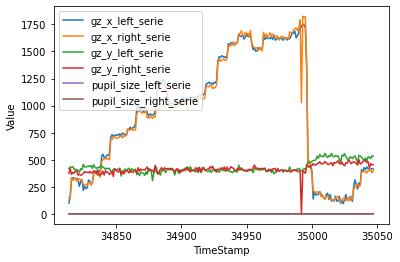

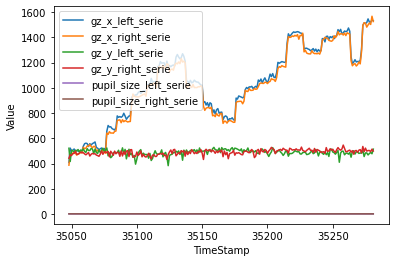

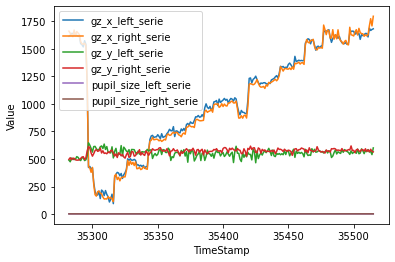

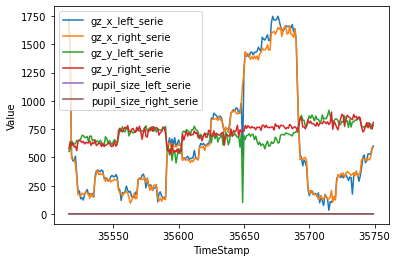

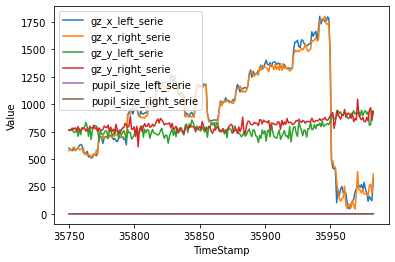

In [15]:
identificators = pd.unique(all_data.derived_data['id'])

for identificator in identificators[-5:]:
    plot_all_signals_from_serie_id(all_data.derived_data, identificator)


In [16]:
all_data.get_derived_data_classes_count()

Estudio    120
Control     64
Name: class, dtype: int64

In [17]:
from utils.data_extraction import Data

X_train, X_test, y_train, y_test = all_data.train_test_split(
    train_size=.75,
    criterion='tfm_marta',
    drop_columns=['class'],
    random_state=1
)
X_train.insert(X_train.shape[1], column='class', value=y_train)
X_test.insert(X_test.shape[1], column='class', value=y_test)

train = Data(X_train)
test = Data(X_test)

In [18]:
train.get_derived_data_classes_count()

Estudio    90
Control    48
Name: class, dtype: int64

In [19]:
test.get_derived_data_classes_count()

Estudio    30
Control    16
Name: class, dtype: int64

# <font color=#cd0000> Aplicación preliminar de las nociones anteriores </font>

In [20]:
from utils.codifications import temporal_trend_fn

# Trend's codification (first derivative)
train.apply_codifications([temporal_trend_fn])
test.apply_codifications([temporal_trend_fn])


In [21]:
# Acceleration's codification (second derivative)
columns_to_derivate = list(filter(lambda z: 'Diff' in z, 
                               train.get_derived_data_columns()['attrs']))

train.apply_codifications([temporal_trend_fn], headers=columns_to_derivate)
test.apply_codifications([temporal_trend_fn], headers=columns_to_derivate)


## <font color=#cd0000> Sobre SMTS </font>

In [22]:
from smts_implementation.smts import SMTS

clf = SMTS(j_ins=10, n_symbols=10, random_state=1)
clf.fit(train.derived_data.drop(['TimeStamp', 'class'], axis=1),
        train.derived_data['class'])
clf.score(test.derived_data.drop(['TimeStamp', 'class'], axis=1),
          test.derived_data['class'])


0.8695652173913043

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(test.derived_data.drop(['TimeStamp', 'class'], axis=1))
y_real = test.derived_data.groupby('id', sort=False).first()['class'].to_numpy()

print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[14  2]
 [ 4 26]]
              precision    recall  f1-score   support

     Control       0.78      0.88      0.82        16
     Estudio       0.93      0.87      0.90        30

    accuracy                           0.87        46
   macro avg       0.85      0.87      0.86        46
weighted avg       0.88      0.87      0.87        46



## <font color=#cd0000> Sobre RF </font>

In [24]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=1, n_estimators=75)
clf.fit(train.derived_data.drop(['id', 'class'], axis=1),
        train.derived_data['class'])
clf.score(test.derived_data.drop(['id', 'class'], axis=1),
          test.derived_data['class'])


0.7703279424977538

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = clf.predict(test.derived_data.drop(['id', 'class'], axis=1))
y_real = test.derived_data['class'].to_numpy()

print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[1968 1308]
 [ 737 4891]]
              precision    recall  f1-score   support

     Control       0.73      0.60      0.66      3276
     Estudio       0.79      0.87      0.83      5628

    accuracy                           0.77      8904
   macro avg       0.76      0.73      0.74      8904
weighted avg       0.77      0.77      0.76      8904



## <font color=#cd0000> Sobre LSTM </font>

### <font color=#cd0000> Preparación de los datos </font>

In [26]:
from utils.codifications import standardize_data

train.derived_data, test.derived_data = standardize_data(
    train.derived_data,
    test.derived_data,
    headers=train.get_derived_data_columns()['attrs']
)

In [27]:
# All lengths must be equal
series_length = train.get_shortest_serie().shape[0]
n_dims = len(train.get_derived_data_columns()['attrs'])

(
    train.get_shortest_serie().shape[0],
    train.get_largest_serie().shape[0],
    test.get_shortest_serie().shape[0],
    test.get_largest_serie().shape[0]
)


(94, 235, 94, 235)

In [28]:
import pandas as pd

# This will determine the number of series of each split
train_n_series = pd.unique(train.derived_data['id']).shape[0]
test_n_series = pd.unique(test.derived_data['id']).shape[0]

(train_n_series, test_n_series)


(138, 46)

In [29]:
X_train, _ = train.transform_derived_data_into_X_y()
X_test, _ = test.transform_derived_data_into_X_y()

y_train = train.derived_data.groupby('id').first()['class'].to_numpy()
y_test = test.derived_data.groupby('id').first()['class'].to_numpy()


In [30]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
enc.fit(y_train)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)


### <font color=#cd0000> Diseño del modelo </font>

In [31]:
import pandas as pd
import numpy as np

cleaned_train = train.derived_data.drop(['TimeStamp', 'class'], axis=1)
cleaned_test = test.derived_data.drop(['TimeStamp', 'class'], axis=1)

X_train =\
    np.array([cleaned_train[cleaned_train['id'] == identif].drop(['id'], axis=1)
          .to_numpy().astype('float32') for identif in pd.unique(train.derived_data['id'])])

X_test =\
    np.array([cleaned_test[cleaned_test['id'] == identif].drop(['id'], axis=1)
              .to_numpy().astype('float32') for identif in pd.unique(test.derived_data['id'])])


C:\Users\Javier\AppData\Local\Temp\ipykernel_4436\2820726610.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([cleaned_train[cleaned_train['id'] == identif].drop(['id'], axis=1)
C:\Users\Javier\AppData\Local\Temp\ipykernel_4436\2820726610.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([cleaned_test[cleaned_test['id'] == identif].drop(['id'], axis=1)


In [32]:
import numpy as np
# Since we have different length sequences we have to put padding & masking to the Neural Net

# This value couldn't be possible in this DS
mask_value = -999
dimension = len(train.get_derived_data_columns()['attrs'])

train_max_seq_len = train.get_largest_serie().shape[0]
test_max_seq_len = test.get_largest_serie().shape[0]
max_seq_len = max(train_max_seq_len, test_max_seq_len)

X_train_padded = np.full((train_n_series, max_seq_len, dimension),
                  fill_value=mask_value, dtype="float32")

for s, x in enumerate(X_train):
    seq_len = x.shape[0]
    X_train_padded[s, 0:seq_len, :] = x

X_test_padded = np.full((test_n_series, max_seq_len, dimension),
                        fill_value=mask_value, dtype="float32")
for s, x in enumerate(X_test):
    seq_len = x.shape[0]
    X_test_padded[s, 0:seq_len, :] = x


In [33]:
import keras as k
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking

nn = Sequential()

# Number of initial dimensions
nn.add(Masking(mask_value=mask_value,
           input_shape=(max_seq_len, 18)))
nn.add(LSTM(units=36, return_sequences=True, dropout=.2, recurrent_dropout=.2))
nn.add(LSTM(units=18, dropout=.2, recurrent_dropout=.2))
# Number of Ocular's classes
nn.add(Dense(1, activation='sigmoid'))


### <font color=#cd0000> Compilación del modelo </font>

In [34]:
from keras.optimizers import RMSprop

metrics = [
    k.metrics.CategoricalAccuracy(name="ACC"),
    k.metrics.Precision(name='Prec'),
    k.metrics.Recall(name='Rec'),
    k.metrics.AUC(name='AUC')
]
nn.compile(optimizer=RMSprop(learning_rate=1e-3), 
           loss='binary_crossentropy', metrics=metrics)

### <font color=#cd0000> Visualización de métricas </font>

In [35]:
import matplotlib.pyplot as plt


def show_metrics(history):
    for metric in history.history.keys():
        if not metric.startswith('val_'):
            plt.plot(history.history[metric], label=metric)
            plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
            plt.title(metric)
            plt.ylabel('')
            plt.xlabel('Epoch')
            plt.legend(loc="upper left")
            plt.show()


### <font color=#cd0000> Entrenamiento </font>

Epoch 1/100
1/1 [==============================] - 1s 992ms/step - loss: 0.6981 - ACC: 1.0000 - Prec: 0.6500 - Rec: 0.4333 - AUC: 0.5162 - val_loss: 0.6816 - val_ACC: 1.0000 - val_Prec: 0.7200 - val_Rec: 0.6000 - val_AUC: 0.6135
Epoch 2/100
1/1 [==============================] - 0s 48ms/step - loss: 0.6741 - ACC: 1.0000 - Prec: 0.7654 - Rec: 0.6889 - AUC: 0.6578 - val_loss: 0.6724 - val_ACC: 1.0000 - val_Prec: 0.7000 - val_Rec: 0.7000 - val_AUC: 0.6260
Epoch 3/100
1/1 [==============================] - 0s 56ms/step - loss: 0.6572 - ACC: 1.0000 - Prec: 0.7526 - Rec: 0.8111 - AUC: 0.7365 - val_loss: 0.6634 - val_ACC: 1.0000 - val_Prec: 0.7188 - val_Rec: 0.7667 - val_AUC: 0.6385
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 0.6421 - ACC: 1.0000 - Prec: 0.7604 - Rec: 0.8111 - AUC: 0.7729 - val_loss: 0.6550 - val_ACC: 1.0000 - val_Prec: 0.6765 - val_Rec: 0.7667 - val_AUC: 0.6542
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 0.6264 - ACC: 1

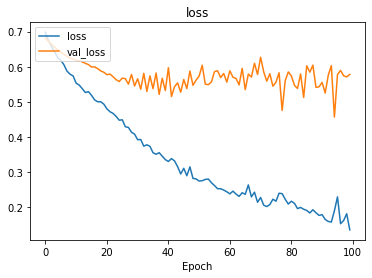

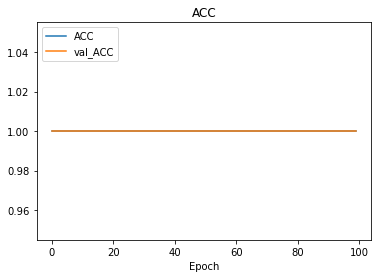

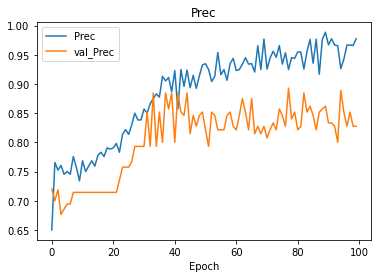

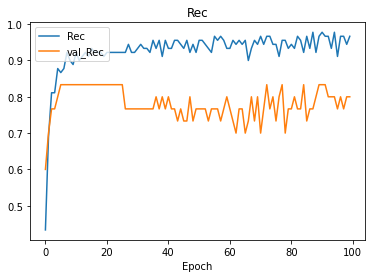

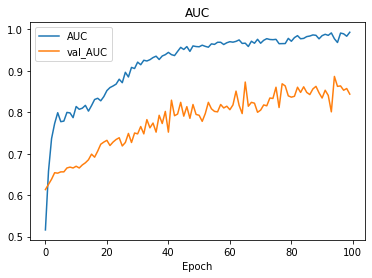

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

epochs = 100

history = nn.fit(X_train_padded, y_train, epochs=epochs,
                 validation_data=(X_test_padded, y_test),
                 batch_size=train.get_largest_serie().shape[0])
nn.summary()
print('\n\n')

y_pred = nn.predict(X_test_padded)
y_pred = y_pred > 0.5

show_metrics(history)


In [37]:
y_pred = enc.inverse_transform(y_pred.astype('int'))
y_real = enc.inverse_transform(y_test)
print(confusion_matrix(y_real, y_pred))
print(classification_report(y_real, y_pred, zero_division=0))

[[11  5]
 [ 6 24]]
              precision    recall  f1-score   support

     Control       0.65      0.69      0.67        16
     Estudio       0.83      0.80      0.81        30

    accuracy                           0.76        46
   macro avg       0.74      0.74      0.74        46
weighted avg       0.76      0.76      0.76        46



c:\Users\Javier\anaconda3\envs\tfg_env\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
